In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
%matplotlib notebook

### proximal minimization

$\operatorname{prox}_{\lambda f}(v)=\underset{x}{\operatorname{argmin}}\left(f(x)+(1 / 2 \lambda)\|x-v\|_{2}^{2}\right)$

$x^{k+1}:=\operatorname{prox}_{\lambda f}\left(x^{k}\right)$

In [3]:
def cost_for(x1, x2, z, f):
    Nx_p = np.shape(x1)[1]
    x_plot = np.vstack((x1,x2))
    print(np.shape(z))
    for i in range(Nx_p):
        z[:,i] = f(x_plot[:,i])

In [4]:
def plot_init(G, c, x1_range = None, x2_range = None, z_range = None):
    if x1_range is None:
        x1_val  = np.arange(-5, 5, 0.1, dtype=np.float32)
    else:
        x1_val = x1_range
    if x2_range is None:
        x2_val = np.arange(-5, 5, 0.1, dtype=np.float32)
    else:
        x2_range = x2_val
    G = ca.DM(G).full()
    c = ca.DM(c).full()
    x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
    x1_val_mesh_flat = x1_val_mesh.reshape([1, -1])
    x2_val_mesh_flat = x2_val_mesh.reshape([1, -1])

    z_val_mesh_flat = np.zeros_like(x1_val_mesh_flat)
    f = lambda x: x.T @ G @ x + c @ x
    cost_for(x1_val_mesh_flat,x2_val_mesh_flat,z_val_mesh_flat,f)

    # z_val_mesh = np.reshape([(lambda x1,x2: (x1-1)**2 + (x2-2.5)**2)(x1,x2) for x1,x2 in zip(x1_val_mesh_flat,x2_val_mesh_flat)],(x1_val_mesh.shape))
    z_val_mesh = np.reshape(z_val_mesh_flat,(x1_val_mesh.shape))

    
    fig = plt.figure(figsize=(6, 4))
    spec=fig.add_gridspec(nrows=1,ncols=1)
    ax1 = fig.add_subplot(spec[0,0],projection='3d' )
    ax1.plot_surface(x1_val_mesh, x2_val_mesh, z_val_mesh, alpha=0.5, cmap=cm.coolwarm)

    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z')
    return ax1

In [5]:
def update_plot(ax, x0, x_update, f_update):
    
    Ni = np.shape(x0)[0]    
    N_plot = np.shape(f_update)[0]
    f_value = f_update[0]
    plot_cache = None
    for n_plot in range(N_plot):
        xk = x_update[Ni * n_plot:Ni * (n_plot + 1)]
        print(xk)
        if n_plot == 0:
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')
            x_past = xk
            f_past = f_value
        else:
            f_value = f_update[n_plot]
            plot_cache.remove()
            plot_cache = ax.scatter(xk[0], xk[1], f_value, s=20, depthshade=True, color='r')
            ax.plot([x_past[0], xk[0]], [x_past[1], xk[1]], [f_past, f_value], linewidth=2, color='r')

            x_past = xk
            f_past = f_value  

In [6]:
class func:
    def __init__(self, G, c):
        Nx = G.shape[0]
        x = ca.SX.sym('x', Nx)
        self.x = x
        p = ca.SX.sym('p', Nx)
        v = ca.SX.sym('v', Nx)
        t = ca.SX.sym('t', 1)
        lambda_ = ca.SX.sym('lambda_', 1)
        f = ca.Function('f', [x], [ x.T @ G @ x + c @ x])
        self.f = f
        self.v = v
        self.lambda_ = lambda_
        Jac = ca.jacobian(f(x),x)
        Jac_func = ca.Function('jacobian',[x],[Jac])
        Hessian = ca.hessian(f(x),x)[0]
        Hessian_func = ca.Function('Hessian',[x],[Hessian])
        f_update_taylor = f(x) + Jac @ p + 1/2 * p.T @ Hessian_func(x + t*p) @ p
        f_update_taylor_func = ca.Function("f_update_func", [t,x,p],[f_update_taylor])
        self.f_update_taylor_func = f_update_taylor_func
        
        f_update_real = f(x + p)
        f_update_real_func = ca.Function("f_update_func", [x,p],[f_update_real])
        self.f_update_real_func = f_update_real_func

In [7]:
def prox_method(solver, f, x0, lambda_, N_pred = 0):
    Nx = np.shape(x0)[0]
    x_update = []
    f_update = []
    xk = x0

    x_update += xk
    f_update += f(xk).full().flatten().tolist()
    for i in range(N_pred):
        p = xk + [lambda_]
        r = solver(x0 = xk, p = p)
        xk = r['x'].full().flatten().tolist()
        x_update += xk
        f_update += f(xk).full().flatten().tolist()
    return x_update, f_update

(1, 10000)


<IPython.core.display.Javascript object>


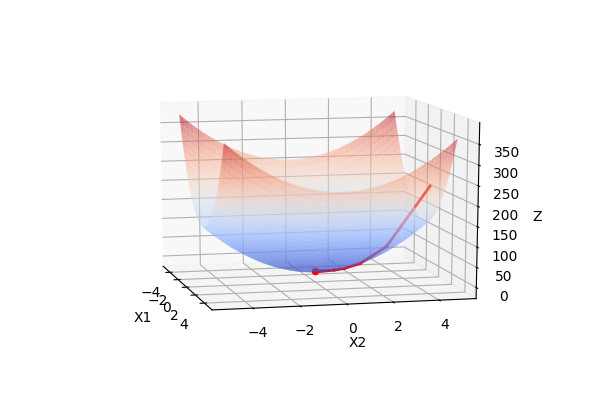

In [8]:
G = ca.SX([[10,0],[0,5]])
c = ca.SX([0,0]).T
x0 = [4,4]

f_func = func(G, c)

f_function = f_func.f
x = f_func.x
f = f_func.f(x)
v = f_func.v
lambda_ = f_func.lambda_

f_prox = f + 1/2 * lambda_ * ca.norm_2(x - v) ** 2
f_prox_func = ca.Function("f_prox_func", [lambda_, x, v], [f_prox])

p = ca.vertcat(v,lambda_)

# Define proximal solver
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

nlp = {'x':x, 'f':f_prox, 'p': p}
solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opt)

ax1 = plot_init(G,c)

In [9]:
lambda_ = 20
x_update,f_update = prox_method(solver, f_function, x0, lambda_, N_pred = 20)
update_plot(ax1,x0,x_update,f_update)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

[4, 4]
[2.0, 2.666666666666667]
[1.0, 1.777777777777778]
[0.5, 1.1851851851851851]
[0.25, 0.7901234567901234]
[0.125, 0.5267489711934156]
[0.0625, 0.3511659807956104]
[0.03125, 0.23411065386374025]
[0.015625, 0.1560737692424935]
[0.0078125, 0.10404917949499567]
[0.00390625, 0.06936611966333045]
[0.001953125, 0.04624407977555363]
[0.0009765625, 0.030829386517035755]
[0.00048828125, 0.020552924344690502]
[0.000244140625, 0.013701949563127001]
[0.0001220703125, 0.009134633042084667]
[6.103515625e-05, 0.006089755361389778]
[3.0517578125e-05, 0.004059836907593185]
[1.52587890625e-05, 0.002706557938395457]
[7.6

(1, 10000)


<IPython.core.display.Javascript object>


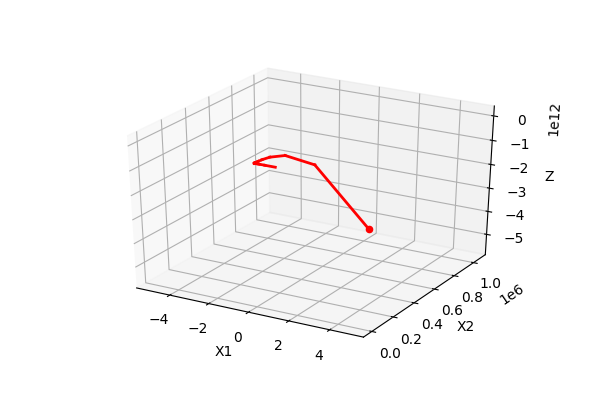

In [10]:
G = ca.SX([[10,0],[0,-5]])
c = ca.SX([0,0]).T
x0 = [1,1]

f_func = func(G, c)

f_function = f_func.f
x = f_func.x
f = f_func.f(x)
v = f_func.v
lambda_ = f_func.lambda_

f_prox = f + 1/2 * lambda_ * ca.norm_2(x - v) ** 2
f_prox_func = ca.Function("f_prox_func", [lambda_, x, v], [f_prox])

p = ca.vertcat(v,lambda_)

# Define proximal solver
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

nlp = {'x':x, 'f':f_prox, 'p': p}
solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opt)

ax2 = plot_init(G,c)

In [11]:
lambda_ = 20
x_update,f_update = prox_method(solver, f_function, x0, lambda_, N_pred = 20)
update_plot(ax2,x0,x_update,f_update)

[1, 1]
[0.5, 2.0]
[0.25, 4.0]
[0.125, 8.0]
[0.0625, 16.0]
[0.03125, 32.0]
[0.015625, 64.0]
[0.0078125, 128.0]
[0.00390625, 256.0]
[0.001953125, 512.0]
[0.0009765625, 1024.0]
[0.00048828125, 2048.0]
[0.000244140625, 4096.0]
[0.0001220703125, 8192.0]
[6.103515625e-05, 16384.0]
[3.0517578125e-05, 32768.0]
[1.52587890625e-05, 65536.0]
[7.62939453125e-06, 131072.0]
[3.814697265625e-06, 262144.0]
[1.9073486328125e-06, 524288.0]
[9.5367431640625e-07, 1048576.0]


## ADMM

### Lasso

$\begin{aligned} x^{k+1} &:=\left(A^{T} A+\rho I\right)^{-1}\left(A^{T} b+\rho\left(z^{k}-u^{k}\right)\right) \\ z^{k+1} &:=S_{\lambda / \rho}\left(x^{k+1}+u^{k}\right) \\ u^{k+1} &:=u^{k}+x^{k+1}-z^{k+1} \end{aligned}$

In [210]:
import numpy as np
from scipy import sparse

In [160]:
def soft_threshold(v,k):
    n = np.shape(v)[0]
    v_new = np.zeros([n,1])
    
    for i in range(n):
        if v[i,0] >= k:
            v_new[i,0] = v[i,0] - k
        elif v[i,0] <= -k:
            v_new[i,0] = v[i,0] + k
        else:
            v_new[i,0] = 0
    return v_new

1. A must be Hermitian (symmetric if real-valued) and positive-definite to apply Cholesky decomposition.

In [211]:
def factor(A, rho):
    
    m, n = A.shape
    if m >= n:
        L = np.linalg.cholesky(np.dot(A.T, A) + rho*np.eye(n))
    else:
        L = np.linalg.cholesky(np.eye(m) + 1/rho*(np.dot(A, A.T)))

    L = L
    U = L.T.conj()
    return L, U

In [185]:
N_sample = 5000    #  Number of samples
Nx = 1500    #  Number of regressor
A = np.random.randn(N_sample,Nx)
A = np.dot(A, sparse.spdiags(1/np.sqrt(sum(np.multiply(A, A))), 0, Nx, Nx).todense())  # make it symmetric and normalize column

x0 = np.random.randn(Nx,1)
indices = np.random.choice(np.arange(x0.size), replace=False,
                           size=int(x0.size * 0.8))
x0[indices] = 0

b = A @ x0 + np.sqrt(0.001)*np.random.randn(N_sample, 1)

lambda_max = np.linalg.norm(np.dot(A.T, b), np.inf)
lambda_ = 0.1*lambda_max

rho = 1.0
alpha = 1.0    #  Over-relaxation: select alpha in [1.5, 1.8] to improve covergence.

N_miter = 100;
x = np.zeros([Nx,1])
z = np.zeros([Nx,1])
u = np.zeros([Nx,1])
err = []    #  Absolute error
err_r = []    #  Relative error
# cache the factorization
L, U = factor(A, rho)
Atb = A.T @ b

for k in range(N_miter):
    
    q = Atb + rho*(z - u)  # temporary value
    if( N_sample >= Nx ):    # if skinny, using direct method with the help of Cholesky decomposition.
        x = np.linalg.solve(U, np.linalg.solve(L, q))
    else:            # if fat, using matrix inversion lemma.
        x = q/rho - A.T @ np.linalg.solve(U, np.linalg.solve(L, A @ q))/rho**2
    zold = z
    x_hat = alpha*x + (1 - alpha)*zold
    
#     x = np.linalg.inv(A.T @ A + rho * np.eye(p)) @ (A.T @ b + rho* (z - u))
    z = soft_threshold(x_hat + u, lambda_/rho)
    u = u + x_hat - z

    err += [np.linalg.norm(x-x0)]
    err_r += [np.linalg.norm(x-z)]

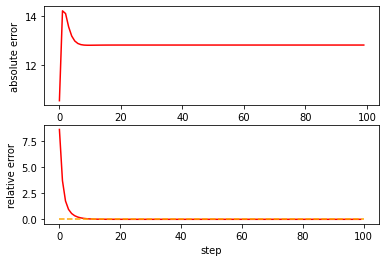

In [206]:
n = np.shape(err)[0]
n = np.arange(n)
plt.figure(1)
plt.clf()

plt.subplot(211)
# plt.grid()
plt.plot(n, err, 'r')
plt.ylabel('absolute error')

plt.subplot(212)
plt.plot(n, err_r, 'r')
plt.hlines(0,0,np.shape(n)[0], colors = 'orange', linestyles = 'dashed', zorder = 10)
plt.ylabel('relative error')
plt.xlabel('step')

plt.show()

### generic ADMM 

$\operatorname{minimize} \quad f(x)+g(x)$

method:

$\begin{aligned} x^{k+1} &:=\operatorname{prox}_{\lambda f}\left(z^{k}-u^{k}\right) \\ z^{k+1} &:=\operatorname{prox}_{\lambda g}\left(x^{k+1}+u^{k}\right) \\ u^{k+1} &:=u^{k}+x^{k+1}-z^{k+1} \end{aligned}$

$\operatorname{prox}_{\lambda f}(v)=\underset{x}{\operatorname{argmin}}\left(f(x)+(1 / 2 \lambda)\|x-v\|_{2}^{2}\right)$

In [207]:
def create_prox_func(Nx,f_func):

    x = ca.SX.sym("x",Nx)
    v = ca.SX.sym("v",Nx)
    lambda_ = ca.SX.sym("lambda",1)
    
    f = f_func(x)
    f_prox = f + 1/2 * lambda_ * ca.norm_2(x - v) ** 2
    f_prox_func = ca.Function("f_prox_func", [lambda_, x, v], [f_prox])

    p = ca.vertcat(v,lambda_)
    
    # Define proximal solver
    solver_opt = {}
    solver_opt['print_time'] = False
    solver_opt['ipopt'] = {
        'max_iter': 500,
        'print_level': 1,
        'acceptable_tol': 1e-6,
        'acceptable_obj_change_tol': 1e-6
    }

    nlp = {'x':x, 'f':f_prox, 'p': p}
    solver = ca.nlpsol('solver', 'ipopt', nlp, solver_opt)
    return solver

In [ ]:
lambda_ = ca.SX.sym("lambda",1)   
Nx = 2
f_func = ...
f_prox_solver = create_prox_func(Nx,f_func)
g_func = ...
g_prox_solver = create_prox_func(Nx,g_func)